In [11]:
import pandas as pd
import numpy as np

random_state = 42
np.random.seed(random_state)
target = 'demand'

In [12]:
url = '../data/power_demand_vs_temperature.csv'
df0 = pd.read_csv(url)
df0.head()

,date,demand,temp
0,2015-01-01,1.736065,1.7
1,2015-01-02,1.831672,2.2
2,2015-01-03,1.714934,14.4
3,2015-01-04,1.628577,15.6
4,2015-01-05,2.045394,0.0


In [13]:
df0.describe()

,demand,temp
count,1096.000000,1096.000000
mean,1.831796,16.927737
std,0.329434,10.791581
min,1.316033,-15.000000
25%,1.581654,8.900000
50%,1.731479,18.900000
75%,2.024869,26.100000
max,2.804025,33.900000


In [14]:
print(f"The dataframe has {df0.shape[0]-df0.dropna().shape[0]} invalid rows")

The dataframe has 0 invalid rows


In [22]:
X = df0.drop([target, 'date'], axis=1)
y = df0[target]
print(f"X has shape{X.shape}")
print(f"Y has shape{y.shape}")

X has shape(1096, 1)
Y has shape(1096,)


In [21]:
import warnings
warnings.filterwarnings("ignore")

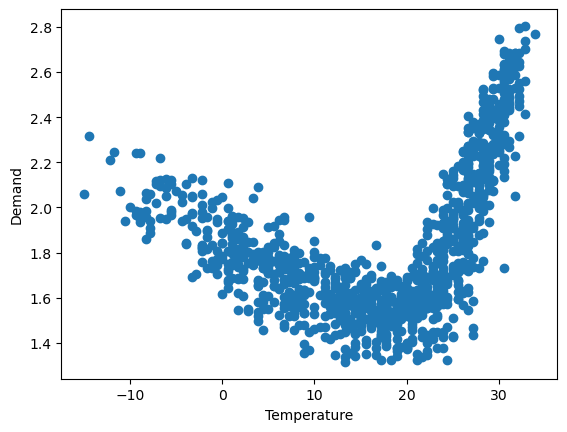

In [23]:
import matplotlib.pyplot as plt

plt.scatter(X,y)
plt.xlabel("Temperature")
plt.ylabel("Demand")
plt.show()

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=random_state, train_size=0.7)
print('Training set and test set have {} and {} elements respectively'.format(X_train.shape[0],X_test.shape[0]))

Training set and test set have 767 and 329 elements respectively


In [30]:
import scipy.stats
from sklearn.metrics import mean_squared_error, r2_score

def f_test(y_true, y_pred, n_var, n_obs):
    """ Computation of F-statistic and p-value for the regression
    http://facweb.cs.depaul.edu/sjost/csc423/documents/f-test-reg.htm
    Requires: np (numpy) and scipy.stats

    Arguments:
    y_true: ground truth
    y_pred: predictions
    n_var: number of predicting variables
    n_obs: number of observations (the length of y_true and y_pred)

    Returns:
    F: F statistics
    p: p-value
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    n = n_obs
    p = n_var+1 # number of regression parameters (coefficients + intercept)
    y_true_m = np.mean(y_true)
    SSM = np.sum((y_pred-y_true_m)**2)
    SST = np.sum((y_true-y_true_m)**2)
    SSE = np.sum((y_true-y_pred)**2)
    DFT = n - 1
    DFM = p - 1 # degrees of freedom for model - numerator
    DFE = n - p # degrees of freedom for error - denominator
    DFT = n - 1
    MSM = SSM / DFM
    MSE = SSE / DFE
    MST = SST / DFT
    F = MSM / MSE
    # f = np.var(x, ddof=1)/np.var(y, ddof=1) #calculate F test statistic
    p = 1-scipy.stats.f.cdf(F, DFM, DFE) #find p-value of F test statistic
    return F, p

def print_eval(X, y, model):
    """ Predicts for X given a fitted model and
        prints prediction quality with respect to y
    Requires f_test (returning F and p-value), mean_squared_error, r2_score

    Arguments:
    X : array-like predicting data
    y : ground truth
    model: predictor fitted model

    Return: MSE, r2_score, F, p-value
    """
    pred = model.predict(X)
    F, p = f_test(y, pred, X.shape[1], X.shape[0])
    print(" Mean squared error: \t{:.5}".format(mean_squared_error(y,pred)))
    print(" r2 score: \t\t{:.5}".format(r2_score(y,pred)))
    print(" f-statistic: \t\t{:.5}".format(F))
    print(" p-value: \t\t{:.5}".format(p))
    return mean_squared_error(pred, y), r2_score(y,pred), F, p


In [31]:
results = {} # prepare a dictionary that will contain the results of the experiments

In [32]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
results['linear'] = print_eval(X_test, y_test, linear_model)

 Mean squared error: 	0.10165
 r2 score: 		0.16809
 f-statistic: 		44.576
 p-value: 		1.0503e-10


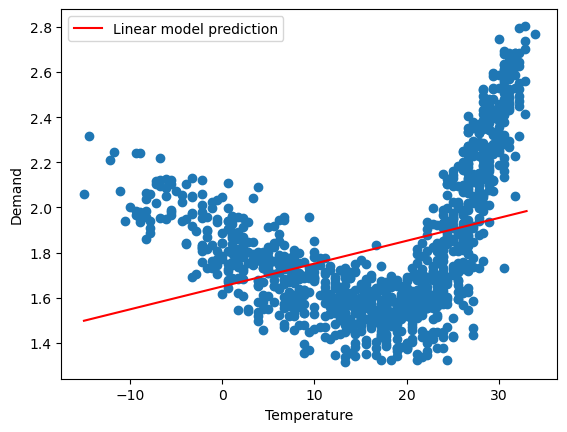

In [36]:
x_axis = np.arange(min(X.temp), max(X.temp))
l_pred = linear_model.predict(x_axis.reshape(-1,1))
plt.plot(x_axis, l_pred, color='red', label='Linear model prediction')
plt.scatter(X,y)
plt.xlabel("Temperature")
plt.ylabel("Demand")
plt.legend()
plt.show()

Polynomial with degree 2
 Mean squared error: 	0.033456
 r2 score: 		0.72619
 f-statistic: 		384.89
 p-value: 		1.1102e-16
Polynomial with degree 3
 Mean squared error: 	0.021749
 r2 score: 		0.822
 f-statistic: 		502.32
 p-value: 		1.1102e-16
Polynomial with degree 4
 Mean squared error: 	0.021334
 r2 score: 		0.8254
 f-statistic: 		390.05
 p-value: 		1.1102e-16


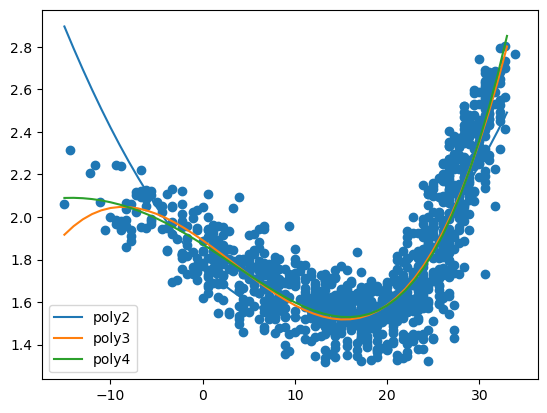

In [39]:
from sklearn.preprocessing import PolynomialFeatures

degrees = list(range(2,5))
for degree in degrees:
  polFea = PolynomialFeatures(degree,include_bias=False)
  X_poly = polFea.fit_transform(X_train.values)#.reshape(-1,1))
  model = LinearRegression()
  model.fit(X_poly, y_train);
  print("Polynomial with degree {}".format(degree))
  results['polynomial'+str(degree)] = print_eval(polFea.transform(X_test), y_test, model)
  pred = model.predict(polFea.transform((np.arange(min(X.temp), max(X.temp))).reshape(-1,1)))
  plt.plot(np.arange(min(X.temp), max(X.temp)),pred, label = "poly"+str(degree))
  plt.legend()
plt.scatter(X,y)
plt.show();

In [40]:
pd.options.display.float_format = '{:,.5f}'.format
res = pd.DataFrame(results, index = ['rmse'
                     , 'r2'
                     , 'f-statistic'
                     , 'p-value'])
res

,linear,polynomial2,polynomial3,polynomial4
rmse,0.10165,0.03346,0.02175,0.02133
r2,0.16809,0.72619,0.82200,0.82540
f-statistic,44.57638,384.88651,502.31829,390.04543
p-value,0.00000,0.00000,0.00000,0.00000
